In [17]:
# Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import plot_roc_curve, roc_curve, auc, RocCurveDisplay

In [ ]:
### Task:

# work with titanic survival data: import, exploration
# data wrangling, imputation, feature engineering
# set up ML model and train on train data
# use model to predict the survival of test data set 
# measure score/accuracy of prediction

In [ ]:
#############################################
### Exploration
#############################################

In [3]:
# read-in data
full_data = pd.read_csv('train.csv')
full_data.shape

(891, 12)

In [5]:
# no of people survived vs. dead:
alive = (full_data['Survived'] == 1).sum()
dead = (full_data['Survived'] == 0).sum()

print(f'total: {alive + dead}, survived: {alive}, not survived: {dead}')

total: 891, survived: 342, not survived: 549


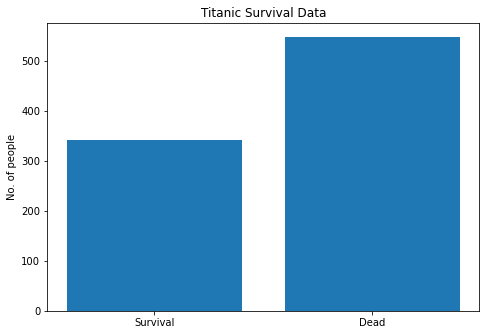

In [7]:
# plot survival data

categories = ['Survival', 'Dead']
data = [(full_data['Survived'] == 1).sum(), (full_data['Survived'] == 0).sum()]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(categories, data)
ax.set_title('Titanic Survival Data')
ax.set_ylabel('No. of people');

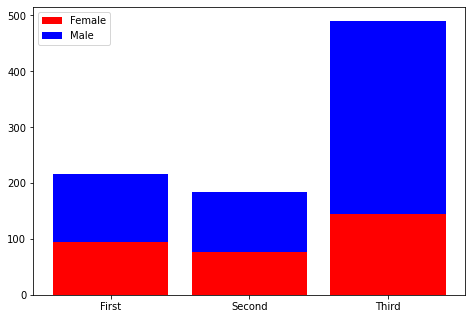

In [12]:
# bar plot: number of people male/female in each class

X = 0
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(0.00, ((full_data['Pclass'] == 1) & (full_data['Sex'] == 'female')).sum(), color = 'r', width = 0.25)
ax.bar(0.00, ((full_data['Pclass'] == 1) & (full_data['Sex'] == 'male')).sum(), width = 0.25, bottom=((full_data['Pclass'] == 1) & (full_data['Sex'] == 'female')).sum(), color='b')

ax.bar(0.30, ((full_data['Pclass'] == 2) & (full_data['Sex'] == 'female')).sum(), color = 'r', width = 0.25)
ax.bar(0.3, ((full_data['Pclass'] == 2) & (full_data['Sex'] == 'male')).sum(), width = 0.25, bottom=((full_data['Pclass'] == 2) & (full_data['Sex'] == 'female')).sum(), color='b')

ax.bar(0.6, ((full_data['Pclass'] == 3) & (full_data['Sex'] == 'female')).sum(), color = 'r', width = 0.25)
ax.bar(0.60, ((full_data['Pclass'] == 3) & (full_data['Sex'] == 'male')).sum(), width = 0.25, bottom=((full_data['Pclass'] == 3) & (full_data['Sex'] == 'female')).sum(), color='b')

ax.set_xticks([0,0.3,0.6], ('First', 'Second', 'Third'))
ax.legend(labels=['Female', 'Male']);

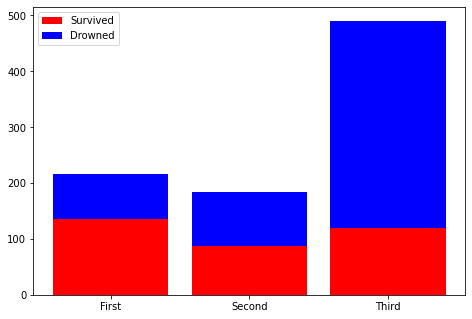

In [14]:
# barplot: no of people survived/drowned in each class

X = 0
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(0.00, ((full_data['Pclass'] == 1) & (full_data['Survived'] == 1)).sum(), color = 'r', width = 0.25)
ax.bar(0.00, ((full_data['Pclass'] == 1) & (full_data['Survived'] == 0)).sum(), width = 0.25, bottom=((full_data['Pclass'] == 1) & (full_data['Survived'] == 1)).sum(), color='b')

ax.bar(0.30, ((full_data['Pclass'] == 2) & (full_data['Survived'] == 1)).sum(), color = 'r', width = 0.25)
ax.bar(0.3, ((full_data['Pclass'] == 2) & (full_data['Survived'] == 0)).sum(), width = 0.25, bottom=((full_data['Pclass'] == 2) & (full_data['Survived'] == 1)).sum(), color='b')

ax.bar(0.6, ((full_data['Pclass'] == 3) & (full_data['Survived'] == 1)).sum(), color = 'r', width = 0.25)
ax.bar(0.60, ((full_data['Pclass'] == 3) & (full_data['Survived'] == 0)).sum(), width = 0.25, bottom=((full_data['Pclass'] == 3) & (full_data['Survived'] == 1)).sum(), color='b')

ax.set_xticks([0,0.3,0.6], ('First', 'Second', 'Third'))
ax.legend(labels=['Survived', 'Drowned']);

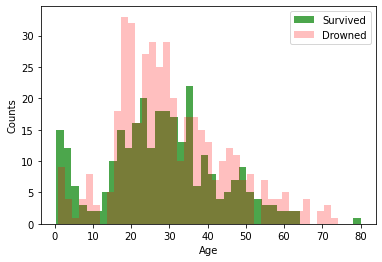

In [16]:
# histplot: age distribution survived/drowned

plt.hist(full_data[full_data['Survived']==1]['Age'], density=False, bins=40, color='green', alpha = 0.7) 
plt.hist(full_data[full_data['Survived']==0]['Age'], density=False, bins=40, color='red', alpha = 0.25) 
plt.ylabel('Counts')
plt.xlabel('Age')
plt.legend(labels=['Survived', 'Drowned']);

In [18]:
# cool ASCII-table with sex, class & survival status

table_list = []
table_list.append(['Class','Female Survivors', 'Female Drowned', 'Male Survivors', 'Male Drowned'])

for pclass in [1, 2, 3]:
    sub_list = []
    sub_list.append(pclass)
    for sex in ['female', 'male']:
        for survival in [1, 0]:
            value = ((full_data['Pclass'] == pclass) & (full_data['Sex'] == sex) & (full_data['Survived'] == survival)).sum()
            sub_list.append(value)
    table_list.append(sub_list)
            
print(tabulate(table_list, headers='firstrow', tablefmt='grid'))

+---------+--------------------+------------------+------------------+----------------+
|   Class |   Female Survivors |   Female Drowned |   Male Survivors |   Male Drowned |
+=========+====================+==================+==================+================+
|       1 |                 91 |                3 |               45 |             77 |
+---------+--------------------+------------------+------------------+----------------+
|       2 |                 70 |                6 |               17 |             91 |
+---------+--------------------+------------------+------------------+----------------+
|       3 |                 72 |               72 |               47 |            300 |
+---------+--------------------+------------------+------------------+----------------+


In [13]:
# List of steps

"""
1. Imputation
- fill in blanks:
;- Age: mean()
- Cabin: "N" for None
- Embarked: forward fill (assuming that the next passenger embarked on the same port as the one before him/her)
2. Preprocessors
List of preprocessors:
- Name: drop
- Sex: One-hot encoding
- Fare: log
- Cabin: one-hot encoding
- Embarked: one-hot encoding
--> normalize whole dataset
3. Split dataset
4. Train
5. Validate
"""

'\n1. Imputation\n- fill in blanks:\n;- Age: mean()\n- Cabin: "N" for None\n- Embarked: forward fill (assuming that the next passenger embarked on the same port as the one before him/her)\n2. Preprocessors\nList of preprocessors:\n- Name: drop\n- Sex: One-hot encoding\n- Fare: log\n- Cabin: one-hot encoding\n- Embarked: one-hot encoding\n--> normalize whole dataset\n3. Split dataset\n4. Train\n5. Validate\n'

In [3]:
###################################################################
###     Feature Engineering
##################################################################

In [12]:
# Imputation

# impute age with mean value
full_data['Age'] = full_data['Age'].replace(to_replace=np.nan, value=full_data['Age'].mean())

# impute cabin info with N 
full_data['Cabin'] = full_data['Cabin'].replace(to_replace=np.nan, value='N')

# forward fill embarkment port
full_data['Embarked'] = full_data['Embarked'].fillna(method='ffill')

# fix for log operation: replace zero values in fare with ones
full_data['Fare'] = full_data['Fare'].replace(to_replace=0, value=1)

In [13]:
# Extract deck and room features from cabin-column
full_data["Deck"] = full_data["Cabin"].str.slice(0,1)
full_data["Room"] = full_data["Cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")

In [14]:
# Impute mean for missing room values
full_data['Room'] = full_data['Room'].replace(to_replace=np.nan, value=full_data['Room'].mean())

In [15]:
# One-Hot-Encoding for sex
encoder = LabelBinarizer()
encoder.fit(full_data['Sex'])
encoder.classes_
full_data['Sex'] = encoder.transform(full_data['Sex'])

In [16]:
# One-Hot-Encoding for embarkment port
encoder = LabelBinarizer()
encoder.fit(full_data['Embarked'])
encoder.classes_
df2 = pd.DataFrame(encoder.transform(full_data['Embarked']), columns=encoder.classes_)
full_data = pd.concat([full_data,df2], axis=1)

In [17]:
# One-Hot-Encoding for Deck 
encoder = LabelBinarizer()
encoder.fit(full_data['Deck'])
encoder.classes_
df2 = pd.DataFrame(encoder.transform(full_data['Deck']), columns=encoder.classes_)
full_data = pd.concat([full_data,df2], axis=1)

In [18]:
# Drop of all columns that have been transformed into before or are supposedly useless
full_data.drop('Name', axis=1, inplace=True)
full_data.drop('PassengerId', axis=1, inplace=True)
full_data.drop('Ticket', axis=1, inplace=True)
full_data.drop('Cabin', axis=1, inplace=True)
full_data.drop('Embarked', axis=1, inplace=True)
full_data.drop('Deck', axis=1, inplace=True)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

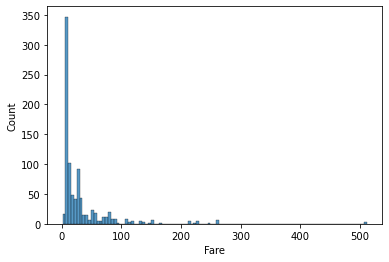

In [19]:
# look at the fares distribution
sns.histplot(full_data['Fare'])

In [20]:
# Convert Fare to log, bc high fares are somewhat out of range for the lower fares to still matter
full_data['Fare'] = np.log(full_data['Fare'])

<AxesSubplot:xlabel='Fare', ylabel='Count'>

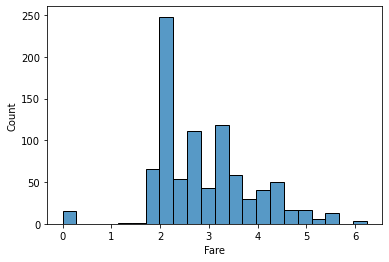

In [22]:
# look at the converted (log) fares
sns.histplot(full_data['Fare'])

In [23]:
# Check if log-operation did create inf values
full_data[full_data.isin([np.inf, -np.inf]).any(axis = 1)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Room,C,Q,S,A,B,C,D,E,F,G,N,T


In [24]:
# Split data into X and y
X, y = full_data.loc[:,'Pclass':], full_data.loc[:,'Survived']

In [25]:
# Train/Test-split and checking of shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((801, 19), (90, 19), (801,), (90,))

In [26]:
# Normalizing of all columns
# fit scaler only on train data, apply to both train and test
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train[:] = scaler.transform(X_train)
X_test[:] = scaler.transform(X_test)

In [19]:
#######################################################################
###                        Build Models
#######################################################################

In [27]:
# Set up model: Log regression and check score
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_train, y_train), log_reg.score(X_test, y_test)

(0.8027465667915106, 0.8222222222222222)

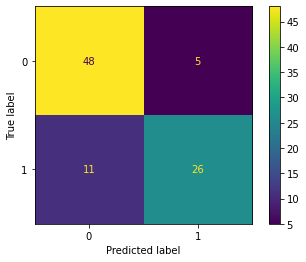

In [28]:
# look at y_true vs. y_hat (confusion matrix)
y_hat = log_reg.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay(conf_mat).plot()

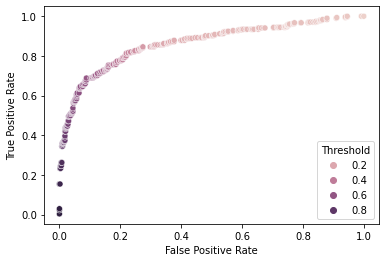

In [29]:
# Check ROC-curve (plotting threshold as color for better understanding of the concept of the curve)
probs = log_reg.predict_proba(X_train) 
fpr, tpr, threshold = roc_curve(y_train, probs[:,1]);

#RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ax = sns.scatterplot(x = fpr[1:], y = tpr[1:], hue = threshold[1:])
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(title='Threshold')

In [31]:
# set up another model (random forest classifier)
forest = RandomForestClassifier(n_estimators=50, max_depth=3)
forest.fit(X_train, y_train)
forest.score(X_train, y_train), forest.score(X_test, y_test)

(0.8102372034956304, 0.8222222222222222)

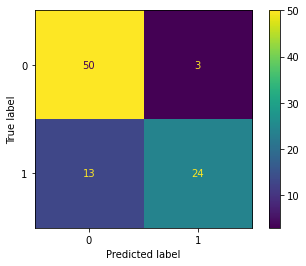

In [32]:
# have a look at the predictions vs. true y
y_hat_f = forest.predict(X_test)
conf_mat_f = confusion_matrix(y_test, y_hat_f)
ConfusionMatrixDisplay(conf_mat_f).plot()

In [ ]:
### ---> logistic regression and random forest yield almost the same score/accuracy